In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import xarray
import firedrake
from firedrake import inner, grad, dx, ds, max_value, sqrt, exp, Constant
import icepack
from icepack.constants import (
    ice_density as rhoI,
    water_density as rhoW,
    gravity as g,
    weertman_sliding_law as m,
)
import modelfunc
from icepack.models.viscosity import viscosity_depth_averaged

### Initial setup

Read in the mesh.

In [2]:
mesh = firedrake.Mesh("DenmanThermalMesh.msh")
Q = firedrake.FunctionSpace(mesh, "CG", 1)
V = firedrake.VectorFunctionSpace(mesh, "CG", 1)

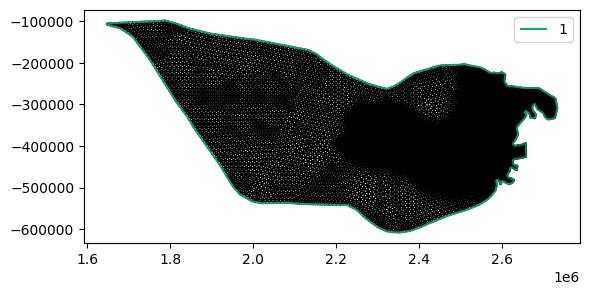

In [3]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(mesh, axes=ax)
ax.legend(loc="upper right");

Read in the velocity data.

In [4]:
measures_filename = icepack.datasets.fetch_measures_antarctica()
measures = xarray.open_dataset(measures_filename)

In [5]:
np.sum(np.isnan(measures["VX"])).data[

SyntaxError: incomplete input (3547787762.py, line 1)

In [ ]:
u_obs = icepack.interpolate((measures["VX"], measures["VY"]), V)
print(np.sum(np.isnan(u_obs.dat.data_ro)))
speed = firedrake.sqrt(firedrake.inner(u_obs, u_obs))

There are some missing points, so just mask them out with 0.
**TODO**: Fix this awfulness.

In [ ]:
u_obs.dat.data[np.isnan(u_obs.dat.data_ro)] = 0
print(np.sum(np.isnan(u_obs.dat.data_ro)))

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
colors = firedrake.tripcolor(u_obs, axes=ax)
fig.colorbar(colors);

Read in the bed, thickness, and surface elevation data.

In [ ]:
bedmachine_filename = icepack.datasets.fetch_bedmachine_antarctica()
bedmachine = xarray.open_dataset(bedmachine_filename)

In [ ]:
b = icepack.interpolate(bedmachine["bed"], Q)
h_obs = icepack.interpolate(bedmachine["thickness"], Q)
h_min = firedrake.Constant(10.0)
h = firedrake.Function(Q).interpolate(max_value(h_min, h_obs))

In [ ]:
zF = modelfunc.flotationHeight(b, Q)
floating, grounded = modelfunc.flotationMask(s, zF, Q)
fig, axes= plt.subplots(1, 3, figsize=(12, 5))
for ax, x in zip(axes.flatten(), [icepack.interpolate(s-zF, Q), floating, grounded]):
    ax.set_aspect("equal")
    colors = firedrake.tripcolor(x, axes=ax)
    #ax.colorbar(colors);

## Surface Temp

In [ ]:
!wget --no-clobber https://store.pangaea.de/Publications/LeBrocq_et_al_2010/ALBMAPv1.nc.zip
!unzip -n ALBMAPv1.nc.zip

In [ ]:
albmap = xarray.open_dataset("ALBMAPv1.nc").rename({"x1": "x", "y1": "y"})
[var for var in albmap.data_vars]

In [ ]:
T_surface = icepack.interpolate(albmap["temp"], Q)
a = icepack.interpolate(albmap["acca"], Q)

## Initial $\beta$

In [ ]:
tauD = firedrake.project(-rhoI * g * h * grad(s), V)
uThresh = firedrake.Constant(300)
#
stress = firedrake.sqrt(firedrake.inner(tauD, tauD))
print('stress', firedrake.assemble(stress * firedrake.dx))
fraction = firedrake.Constant(0.95)
U = max_value(speed, 1)
C = fraction * stress / U**(1/m)
mExp = 1/m + 1
U0 = firedrake.Constant(uThresh)
C = C * (m/(m+1)) * (U0**mExp + U**mExp)**(1/(m+1))
beta = icepack.interpolate(firedrake.sqrt(C) * grounded, Q)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for ax, x in zip(axes.flatten(), [tauD, beta]):
    ax.set_aspect("equal")
    colors = firedrake.tripcolor(x, axes=ax)

## Friction Function

In [ ]:
friction = modelfunc.schoofFriction

## Initial Fluidity

In [ ]:
T = firedrake.Function(Q).interpolate(T_surface + 273.15)
A_0 = icepack.interpolate(icepack.rate_factor(T), Q)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 5))
for ax, x in zip(axes.flatten(), [T, A_0]):
    ax.set_aspect("equal")
    colors = firedrake.tripcolor(x, axes=ax)

## Viscosity Function

In [ ]:
def viscosity(velocity, thickness, fluidity):
    print('here', np.max(thickness.dat.data_ro), np.max(fluidity.dat.data_ro))
    #A = A_0 * exp(log_fluidity)
    return viscosity_depth_averaged(velocity=velocity, thickness=thickness, fluidity=fluidity)


## Model

In [ ]:
def printExtremes(**kwargs):
    ''' Print min/max of firedrake functions to flag bad inputs'''
    Print('Min/Max of input values')
    Print(''.join(['-']*40))
    for arg in kwargs:
        Print(arg, kwargs[arg].dat.data_ro.min(),
              kwargs[arg].dat.data_ro.max())
    Print(''.join(['-']*40))

In [ ]:
printExtremes(h=h, s=s, A_0=A_0, beta=beta)

In [ ]:
model = icepack.models.IceStream(friction=friction, viscosity=viscosity)
opts = {
    "dirichlet_ids": [1]}
#    "diagnostic_solver_type": "petsc",
#    "diagnostic_solver_parameters": {
#        #"snes_monitor": None,
#        "snes_type": "newtonls",
#        "snes_linesearch_type": "cp",
#        "ksp_type": "gmres",
#        "pc_type": "lu",
#        "pc_factor_mat_solver_type": "mumps",
#    },
#}
solver = icepack.solvers.FlowSolver(model, **opts)




In [ ]:
u = solver.diagnostic_solve(velocity=u_obs, thickness=h, surface=s,
                            fluidity=A_0,
                            beta=beta, grounded=grounded,
                            uThresh=uThresh)

In [ ]:
type(uThresh)